In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2 as cv
from datetime import datetime
import os
import segmentation_models_pytorch as smp

%matplotlib inline

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

SEED = 42

In [4]:
class TileNineByNine(Dataset):

    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH):

        self.tile_meta = tile_meta_path
        self.polygons = json_file
        self.images_path = images_path

    def __len__(self):
        return len(self.polygons)

    @property
    def tile_meta(self):
        return self.__tile_meta

    @tile_meta.setter
    def tile_meta(self, val):
        with open(val) as f:
            self.__tile_meta = pd.read_csv(f)

    @property
    def polygons(self):
        return self.__polygons

    @polygons.setter
    def polygons(self, val):
        with open(val) as f:
            self.__polygons = pd.read_json(f, lines=True)

    def transformation(self, image, mask):

        need_crop = (image.shape[0] > 512)

        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)

        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
#         rotate_params = transforms.RandomRotation.get_params((-60, 60))

        flip = np.random.random()

        flip_v = np.random.random()

        jitter = np.random.random()

        if jitter > 0.5:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)

        image = TF.rotate(image,rotate_params)

        if flip > 0.7:
            image = TF.hflip(image)

        if flip_v > 0.7:
            image = TF.vflip(image)

        mask_img = TF.rotate(mask_img,rotate_params)

        if flip > 0.7:
            mask_img = TF.hflip(mask_img)

        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)

        input_image_size = (512, 512)

        if need_crop:
            crop_size = np.random.choice(range(412, 812))
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)

        else:
            crop_size = np.random.choice(range(412, 512))
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)

        mask = (np.array(mask_img))

        return (image, mask)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        img_name = self.polygons.iloc[index, 0]

        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')

        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)

        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]

        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()

        init_row = row_coord - 512

        is_blank_flag = False

        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):

                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]

                if image_small_name.empty:
                    is_blank_flag = True
                    image_large = np.array(image)

                    mask_large = np.zeros((512, 512), dtype=np.uint8)

                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)

                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)

                    break

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')

                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)

                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()

                mask = np.zeros((512, 512), dtype=np.uint8)

                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)

                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)

                mask_large[y:y+512,x:x+512] = mask

                x += 512
                init_col += 512

            if is_blank_flag:
                break
            y += 512
            init_row += 512

        image_large, mask_large = self.transformation(image_large, mask_large)

        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()

        image_large = norm(torch.tensor(image_large.astype(np.float32)))

        return image_large, mask_large.astype(np.float32)

In [5]:
dataset = TileNineByNine()

In [6]:
dataset.__len__()

1633

In [7]:
def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """

    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))

    return average_array

def init_dataloaders(batch_size):

    train_data = TileNineByNine()

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    return train_loader

def train_model(model, loss_func_focal, loss_func_dice, n_epochs, lr, wd, gamma):

    warmup_steps = 7

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma, verbose=True)
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 2e-02, 1, warmup_steps, verbose=True)
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    losses_train = np.zeros(n_epochs)

    for i in range(n_epochs):
        model.train()
        losses_epoch_train = []

        t0 = datetime.now()

        for inputs, targets in tqdm(train_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)
                loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)
                # loss = loss_func(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            losses_epoch_train.append(loss.item())

        if i < warmup_steps:
            warmup_scheduler.step()
        else:
            lr_scheduler.step()

        losses_train[i] = np.mean(losses_epoch_train)

        dt = datetime.now() - t0

        print(f'Epoch: {i+1}/{n_epochs}')
        print(f'Train loss: {losses_train[i]:.3f}')
        torch.cuda.empty_cache()

    return model, losses_train

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-06.


100%|██████████| 326/326 [04:05<00:00,  1.33it/s]


Adjusting learning rate of group 0 to 1.6000e-05.
Epoch: 1/50
Train loss: 1.223


100%|██████████| 326/326 [04:05<00:00,  1.33it/s]


Adjusting learning rate of group 0 to 3.0000e-05.
Epoch: 2/50
Train loss: 1.031


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 4.4000e-05.
Epoch: 3/50
Train loss: 0.928


100%|██████████| 326/326 [03:53<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 5.8000e-05.
Epoch: 4/50
Train loss: 0.880


100%|██████████| 326/326 [03:49<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 7.2000e-05.
Epoch: 5/50
Train loss: 0.866


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 8.6000e-05.
Epoch: 6/50
Train loss: 0.861


100%|██████████| 326/326 [03:47<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 7/50
Train loss: 0.856


100%|██████████| 326/326 [03:53<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.9000e-05.
Epoch: 8/50
Train loss: 0.856


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.8010e-05.
Epoch: 9/50
Train loss: 0.846


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 9.7030e-05.
Epoch: 10/50
Train loss: 0.845


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 9.6060e-05.
Epoch: 11/50
Train loss: 0.851


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 9.5099e-05.
Epoch: 12/50
Train loss: 0.847


100%|██████████| 326/326 [03:57<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 9.4148e-05.
Epoch: 13/50
Train loss: 0.830


100%|██████████| 326/326 [03:50<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 9.3207e-05.
Epoch: 14/50
Train loss: 0.831


100%|██████████| 326/326 [03:53<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 9.2274e-05.
Epoch: 15/50
Train loss: 0.836


100%|██████████| 326/326 [04:01<00:00,  1.35it/s]


Adjusting learning rate of group 0 to 9.1352e-05.
Epoch: 16/50
Train loss: 0.825


100%|██████████| 326/326 [03:55<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 9.0438e-05.
Epoch: 17/50
Train loss: 0.831


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 8.9534e-05.
Epoch: 18/50
Train loss: 0.830


100%|██████████| 326/326 [03:50<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 8.8638e-05.
Epoch: 19/50
Train loss: 0.827


100%|██████████| 326/326 [03:53<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 8.7752e-05.
Epoch: 20/50
Train loss: 0.822


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 8.6875e-05.
Epoch: 21/50
Train loss: 0.827


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 8.6006e-05.
Epoch: 22/50
Train loss: 0.825


100%|██████████| 326/326 [03:57<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 8.5146e-05.
Epoch: 23/50
Train loss: 0.820


100%|██████████| 326/326 [03:53<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 8.4294e-05.
Epoch: 24/50
Train loss: 0.811


100%|██████████| 326/326 [03:58<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 8.3451e-05.
Epoch: 25/50
Train loss: 0.819


100%|██████████| 326/326 [03:57<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 8.2617e-05.
Epoch: 26/50
Train loss: 0.815


100%|██████████| 326/326 [03:58<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 8.1791e-05.
Epoch: 27/50
Train loss: 0.820


100%|██████████| 326/326 [03:59<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 8.0973e-05.
Epoch: 28/50
Train loss: 0.816


100%|██████████| 326/326 [04:01<00:00,  1.35it/s]


Adjusting learning rate of group 0 to 8.0163e-05.
Epoch: 29/50
Train loss: 0.816


100%|██████████| 326/326 [04:02<00:00,  1.35it/s]


Adjusting learning rate of group 0 to 7.9361e-05.
Epoch: 30/50
Train loss: 0.821


100%|██████████| 326/326 [03:57<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 7.8568e-05.
Epoch: 31/50
Train loss: 0.818


100%|██████████| 326/326 [03:58<00:00,  1.37it/s]


Adjusting learning rate of group 0 to 7.7782e-05.
Epoch: 32/50
Train loss: 0.831


100%|██████████| 326/326 [03:52<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 7.7004e-05.
Epoch: 33/50
Train loss: 0.817


100%|██████████| 326/326 [03:55<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 7.6234e-05.
Epoch: 34/50
Train loss: 0.825


100%|██████████| 326/326 [04:07<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 7.5472e-05.
Epoch: 35/50
Train loss: 0.820


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 7.4717e-05.
Epoch: 36/50
Train loss: 0.827


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 7.3970e-05.
Epoch: 37/50
Train loss: 0.817


100%|██████████| 326/326 [03:59<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 7.3230e-05.
Epoch: 38/50
Train loss: 0.821


100%|██████████| 326/326 [03:52<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 7.2498e-05.
Epoch: 39/50
Train loss: 0.819


100%|██████████| 326/326 [03:47<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 7.1773e-05.
Epoch: 40/50
Train loss: 0.816


100%|██████████| 326/326 [03:52<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 7.1055e-05.
Epoch: 41/50
Train loss: 0.811


100%|██████████| 326/326 [03:50<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 7.0345e-05.
Epoch: 42/50
Train loss: 0.822


100%|██████████| 326/326 [03:53<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 6.9641e-05.
Epoch: 43/50
Train loss: 0.809


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 6.8945e-05.
Epoch: 44/50
Train loss: 0.822


100%|██████████| 326/326 [03:52<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 6.8255e-05.
Epoch: 45/50
Train loss: 0.813


100%|██████████| 326/326 [03:51<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 6.7573e-05.
Epoch: 46/50
Train loss: 0.815


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 6.6897e-05.
Epoch: 47/50
Train loss: 0.810


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 6.6228e-05.
Epoch: 48/50
Train loss: 0.818


100%|██████████| 326/326 [03:54<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 6.5566e-05.
Epoch: 49/50
Train loss: 0.818


100%|██████████| 326/326 [03:56<00:00,  1.38it/s]

Adjusting learning rate of group 0 to 6.4910e-05.
Epoch: 50/50
Train loss: 0.812


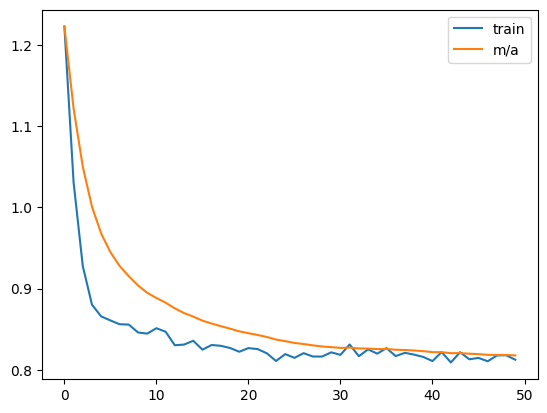

Time elapsed: 3:16:29.278078


In [8]:
BS = 5
N_EPOCHS = 50
LR = 1e-04
WD = 1e-04
GAMMA = 0.99

scores_best = []
scores_wsi = []


T0 = datetime.now()
train_loader = init_dataloaders(BS)

model = smp.Unet(encoder_name='mit_b4',
                     encoder_weights='imagenet',
                     decoder_channels=(512, 256, 128, 64, 32),
                     decoder_use_batchnorm=True,
                     classes=3,
                     activation=None)

model.segmentation_head[2] = nn.Softmax(dim=1)



loss_func_dice = smp.losses.DiceLoss(mode='multiclass')
# loss_func = nn.CrossEntropyLoss(weight=weights)
loss_func_focal = smp.losses.FocalLoss(mode='multiclass')
# loss_func = torchvision.ops.focal_loss()

model, train_losses = train_model(model, loss_func_focal, loss_func_dice, N_EPOCHS, LR, WD, GAMMA)

plt.plot(train_losses, label='train')
plt.plot(moving_average(train_losses), label='m/a')
plt.legend()
plt.show()

T1 = datetime.now() - T0

print(f"Time elapsed: {T1}")

In [9]:
torch.save(model.state_dict(), r"models\HuBMAP_#58.pt")